## Working with MultiDimensional Image Service with Raster Analytics


#### Connect to ArcGIS Online (AGOL) or an ArcGIS Enterprise Portal to save outputs

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster import *

ModuleNotFoundError: No module named 'arcgis'

In [7]:
# Connect to your ArcGIS Enteprise or AGOL
portal_url = 'https://gis.earthdata.nasa.gov/portal'
gis = GIS(portal_url) #anonymous user

In [59]:
# Check the version of Python API
arcgis.__version__

'2.2.0.1'

In [60]:
#query Portal Content
query="TEMPO_l3_tropo_RFT_test"
max_items=3
portal_content = gis.content.advanced_search(query=query, max_items=max_items)
for item in portal_content['results']:
        display (item)

<Item title:"TEMPO_l3_tropo_RFT_test" type:Imagery Layer owner:ASDC_Publisher>

In [61]:
tempo_l3_layer="73a4af425a584a61a34fcff4b9cb013e"
tempo_l3_layer=gis.content.get(tempo_l3_layer)
tempo_l3_layer

<Item title:"TEMPO_l3_tropo_RFT_test" type:Imagery Layer owner:ASDC_Publisher>

In [64]:
m = gis.map()
m.add_layer(tempo_l3_layer)
m.time_slider = True
#m.center = [34.09042, -118.71511]  # [latitude, longitude]
#m.zoom = 11
m

MapView(layout=Layout(height='400px', width='100%'), time_slider=True)

# Using the Image Service API

Resource: https://developers.arcgis.com/python/guide/using-imagery-layers/

In [8]:
# Load data from REST end point
service_url = "https://gis.earthdata.nasa.gov/UAT/rest/services/TEMPO_testing/L3_No2_tropo_2day_sample/ImageServer"
md_raster = Raster(service_url, is_multidimensional=True, engine=None, gis=gis)

In [9]:
#Print Image Service Multidimensional Info
print (md_raster.multidimensional_info)

{'multidimensionalInfo': {'variables': [{'name': '/product/main_data_quality_flag', 'description': 'main data quality flag', 'unit': '', 'dimensions': [{'name': 'StdTime', 'field': 'StdTime', 'description': '', 'unit': '', 'interval': 37.1, 'hasRegularIntervals': False, 'intervalUnit': 'Minutes', 'extent': ['2024-02-26T12:31:45+00:00', '2024-02-28T23:31:39+00:00'], 'hasRanges': False, 'values': ['2024-02-26T12:31:45+00:00', '2024-02-26T13:11:50+00:00', '2024-02-26T13:51:55+00:00', '2024-02-26T14:51:55+00:00', '2024-02-26T15:51:55+00:00', '2024-02-26T16:51:55+00:00', '2024-02-26T17:51:55+00:00', '2024-02-26T18:51:55+00:00', '2024-02-26T19:51:55+00:00', '2024-02-26T20:51:55+00:00', '2024-02-26T21:51:55+00:00', '2024-02-26T22:51:55+00:00', '2024-02-26T23:32:00+00:00', '2024-02-27T12:31:35+00:00', '2024-02-27T13:11:40+00:00', '2024-02-27T13:51:45+00:00', '2024-02-27T14:51:45+00:00', '2024-02-27T15:51:45+00:00', '2024-02-27T16:51:45+00:00', '2024-02-27T17:51:45+00:00', '2024-02-27T22:14:39+

In [10]:
# Print basic information about the multidimensional dataset
print(f"Dataset extent: {md_raster.extent}")
print(f"Variable names: {md_raster.variable_names}")
#print(f"Time extent: {md_raster.time_extent}")

Dataset extent: {
  "xmin": -18701675.0648,
  "ymin": 1572616.1891056262,
  "xmax": -1447154.683753077,
  "ymax": 12123477.103399998,
  "spatialReference": {
    "wkid": 102100,
    "latestWkid": 3857
  }
}
Variable names: ['/product/main_data_quality_flag', '/product/vertical_column_troposphere', '/support_data/eff_cloud_fraction']


In [11]:
# Check your Raster function templates
md_imagery = ImageryLayer(service_url, gis=gis)

for fn in md_imagery.properties.rasterFunctionInfos:
    print(fn['name'])

TEMPO_L3_NO2_Tropo_RFT
None
/product/main_data_quality_flag
/product/vertical_column_troposphere
/support_data/eff_cloud_fraction


In [13]:
#Generate Temporal Profile graph
from arcgis.geometry import *

#Geometry
point1 = Point({"x" : 25.773, "y" : -80.216, "spatialReference" : {"wkid" : 3857}})
point2 = Point({"x" : 0, "y" : 0, "spatialReference" : {"wkid" : 3857}})

#Trend Type
trend_type ="linear" #linear

#Variables
myvars= [r"/product/vertical_column_troposphere"]

#Temporal Profile
md_imagery.temporal_profile(points = [point1,point2], time_field = "StdTime", variables = myvars,  trend_type=trend_type)

Exception: Invalid or missing input parameters.
Unable to instantiate class for xml schema type: 
(Error Code: 400)

# Using Raster Functions on Imagery Layer

Resource: https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html#clip

## Set extent, clip and display ouput in map with basemap


<Item title:"World Continents" type:Feature Layer Collection owner:esri_dm>
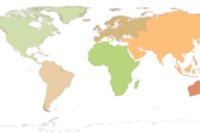

In [15]:
# Access the World contient item from the Living Atlas to use it as a boundary extent.
# Title: World Continents | Type: Feature Service | Owner: esri_livingatlas

gis_agol = GIS('home') #AGOL anonymous user
item = gis_agol.content.get("57c1ade4fa7c4e2384e6a23f2b3bd254")
item

In [16]:
data = ImageryLayer(service_url, gis=gis)

#Now get the extent for the area you would like to select. In this case, I selected Australia
from arcgis.geocoding import geocode

# Use geocoding to get the location of the study area in the spatial reference of the input data for the analysis.
study_area_location = geocode(address='australia', out_sr=data.extent['spatialReference'])

# Get the geographic extent of the study area.
# This extent will be used for displaying the input data and output results.
study_area_extent = study_area_location[0]['extent']
study_area_extent

{'xmin': 111.547031198,
 'ymin': -48.64693157,
 'xmax': 157.421031198,
 'ymax': -2.77293157}

## Clip to a spatial extent

In [17]:
from arcgis.raster.functions import clip #Import clip function

# Select Australia:
country_lyr = item.layers[0]
study_area_query = country_lyr.query("CONTINENT='australia'", return_geometry=True)

# Get the geometry of the Australia feature.
# We will use this geometry to extract the input data for the study area.
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

#study_area_geom

# Set your extend
data.extent = study_area_extent

#draw output on map
Clipped_study_area = clip(raster=data, geometry=study_area_geom)
map = gis.map("Australia")
map.time_slider = True
map.add_layer(Clipped_study_area)
map

MapView(layout=Layout(height='400px', width='100%'), time_slider=True)

## Export subsetted file to a Tiff File

In [ ]:
#Export Image
#ADD FILTER FOR SINGLE RASTER
imagery_layer.export_image(size=[1400, 600],
                           export_format="tiff",
                           f="image",
                           save_folder=r"/path/to/save_folder",
                           save_file="my_raster.tif")

# Using analytics module -  Subset Multidimensional Raster Function

Resource: https://developers.arcgis.com/python/api-reference/arcgis.raster.analytics.html#subset-multidimensional-raster

In [ ]:
# This creates a new multidimensional image service with variables cceiling and ccover for StdTime  dimensions
# values - 2018-12-31T06:00:00 and  2018-12-31T11:00:00
from arcgis.raster.analytics import subset_multidimensional_raster
subset_output = subset_multidimensional_raster(input_multidimensional_raster=Clipped_study_area, 
                                               variables=["T2M"],
                                               dimension_definition='BY_VALUE',
                                               dimension_values=[{"dimension":"StdTime", "value":"2018-12-31T06:00:00"},
                                                                 {"dimension":"StdTime", "value":"2018-12-31T11:00:00"}],
                                               output_name="time_subset_T2M_aus", 
                                               gis=gis)

In [ ]:
lyr = subset_output.layers[0]

In [ ]:
lyr.extent = study_area_extent

In [ ]:
lyr

In [ ]:
savedimg = lyr2.export_image(f='image', export_format='tiff', save_folder='.', save_file='australia_subset.tif')

In [ ]:
# Check your Raster function templates

for fn in data.properties.rasterFunctionInfos:
    print(fn['name'])

In [ ]:
# Select the variable you would like from RFT for vizualization
from arcgis.raster.functions import apply
apply(data,"all_sfc_sw_diff")

#apply(data,"Clear-Sky Surface Short Wave Diffuse Flux")

In [ ]:
#create histogram of area in service
ida = {
        "spatialReference": {"wkid": 4326},
        "xmax": -81,
        "xmin": -91,
        "ymax": 30,
        "ymin": 23
      }

#aoi_geometry = Geometry(aoi)

comp_stats_hist_01 = data.compute_stats_and_histograms(geometry=ida,
                                                          rendering_rule={"rasterFunction":None},
                                                          time="1630211400000")
print(comp_stats_hist_01)


In [ ]:
.